# Audio generation example
#### following https://gist.github.com/naotokui/12df40fa0ea315de53391ddc3e9dc0b9



In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from pydub import AudioSegment

%matplotlib inline

track_path = 'source/raingurl.wav'

### if need to convert mp3 -> wav

In [2]:
if track_path.endswith("mp3"):
    track = AudioSegment.from_mp3(track_path)
    track_path = track_path.replace("mp3", "wav")
    track.export(track_path, format="wav")

### now get to work

In [3]:
sample_rate = 32000
y, _ = librosa.load(track_path, sr=sample_rate, mono=True, offset=68, duration=80)
print(y.shape)

y = y[530000:560000]

min_y = np.min(y)
max_y = np.max(y)

y = (y - min_y) / (max_y - min_y)
print(y.dtype, min_y, max_y)

Audio(y, rate=sample_rate)

(2560000,)
float32 -0.984327 1.03258


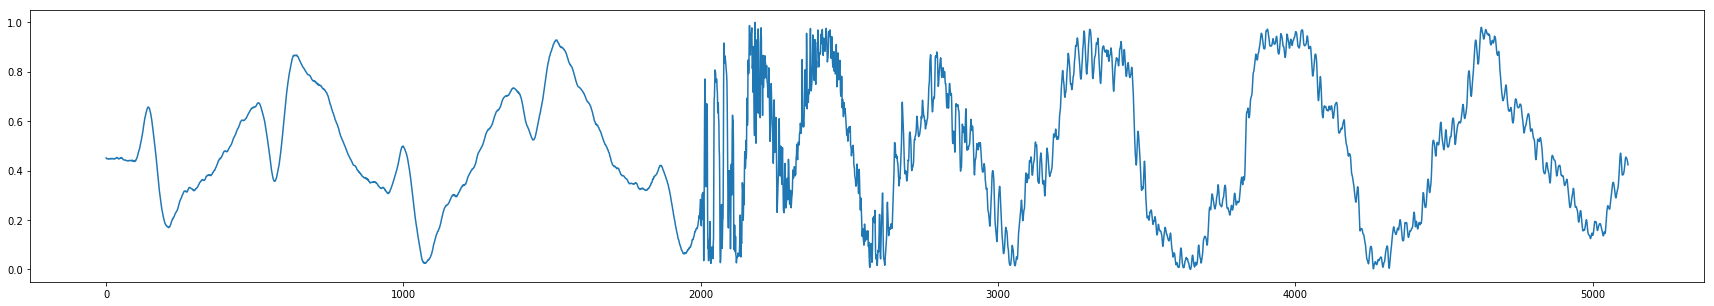

In [4]:
plt.figure(figsize=(30, 5))
plt.plot(y[20000:25120])
plt.show()

### build model

In [5]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # what is this for??

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.optimizers import RMSprop
import tensorflow as tf

window_size = 128
nb_output = 256 # resolution - 8-bit encoding IGNORE THIS FOR THIS EDIT
latent_dim = 128

inputs = Input(shape=(window_size, 1))
x = LSTM(latent_dim, return_sequences=True)(inputs)
x = Dropout(0.4)(x)
x = LSTM(latent_dim)(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='softmax')(x)
model = Model(inputs, output)
print(model.summary())

optimizer = RMSprop(lr=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 128)          66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
None

In [6]:
from tqdm import tqdm

# estimate (0 - 255) based on 256 previous samples
step = 5

samples = []
next_samples = []

for j in tqdm(range(0, y.shape[0] - window_size, step)):
    seq = y[j: j + window_size + 1]
    window = y[j : j + window_size]
    next_sample = y[j + window_size + 1]

    samples.append(window)
    next_samples.append(next_sample)
    
    
    
samples = np.array(samples, dtype='float32')
next_samples = np.array(next_samples, dtype='float32')

samples = samples.reshape(-1, window_size, 1)
next_samples = next_samples.reshape(-1, 1)
print(samples.shape, next_samples.shape)
    

100%|██████████| 5975/5975 [00:00<00:00, 587609.71it/s]

(5975, 128, 1) (5975, 1)


### prep and fit model

In [7]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
csv_logger = CSVLogger('training_audio.log')
escb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
checkpoint = ModelCheckpoint('models/audio-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, period=2)

model.fit(samples, next_samples, shuffle=True, batch_size=256, verbose=1, validation_split=0.1, epochs=500, 
          callbacks=[csv_logger, checkpoint])

Train on 5377 samples, validate on 598 samples
Epoch 1/500
5377/5377 [==============================] - 24s 5ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/500
5377/5377 [==============================] - 23s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/500
5377/5377 [==============================] - 

5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 48/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 50/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 52/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 54/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/500
5377/5377 [==============================] - 24s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e

KeyboardInterrupt: 

In [ ]:
print("training History")
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(model.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(model.history.history['val_loss'])
ax2.set_title('validation loss')

In [ ]:
from IPython.display import display

def sample(preds, temperature=1.0, min_value=0, max_value=1):
    #helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    v = np.argmax(probas)/float(probas.shape[1])
    return v * (max_value - min_value) + min_value

for start in range(50000, 300000, 100000):
    seq = y[start: maxlen]
    seq_matrix = np.zeros((maxlen, nb_output), dtype=bool)
    for i,s in enumerate(seq):
        sample_ = int(s * (nb_output - 1)) # 0-255
        seq_matrix[i, sample_] = True
    
    for i in tqdm(range(50000)):
        z = model.predict(seq_matrix.reshape((1, maxlen, nb_output)))
        s = sample(z[0], 1.0)
        seq = np.append(seq, s)
        
        sample_ = int(s * (nb_output - 1))
        seq_vec = np.zeros(nb_output, dtype=bool)
        seq_vec [sample_] = True
        
        seq_matrix = np.vstack((seq_matrix, seq_vec))
        seq_matrix = seq_matrix[1:]
        
    # scale back
    seq = seq * (max_y - min_y) + min_y
    
    # plot
    plt.figure(figsize=(30,5))
    plt.plot(seq.transpose())
    plt.show()
    
    display(Audio(seq, rate=sample_rate))

In [ ]:
#scale back does this bit do anything?
seq = seq * (max_y - min_y) + min_y

# plot
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(2, 1, 1)
plt.plot(seq.transpose())

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(seq[:30000].transpose())
plt.show()

display(Audio(seq, rate=sample_rate))